Keras используется для построения модели тонкой настройки VGGNet-16, которая замораживает слои и переопределяет их.

In [ ]:
import keras
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras import applications
import tensorflow as tf
import tensorflow.keras.preprocessing.image
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop

# Загрузка и обработка датасета cifar10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

170498071/170498071 [==============================] - 4s 0us/step


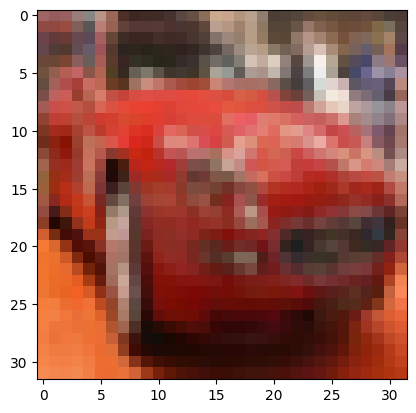

Номер класса: [1]
Тип объекта: автомобиль


In [ ]:
n = 5
plt.imshow(x_train[n])
plt.show()
print("Номер класса:", y_train[n])
print("Тип объекта:", classes[y_train[n][0]])

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 1. VGG16 с тонкой настройкой
Заморозка опорной сети (первые 18 слоев), используется небольшая скорость обучения для тонкой настройки классификационного заголовка, начальная скорость обучения lr=0.0001, оптимизатор RMSprop, и тонкая настройка 15/20 эпох.

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Resizing

vgg16 = applications.VGG16(weights='imagenet',
                    include_top=False,
                    classes=10,
                    input_shape=(None,None,3)# input: 32x32 images with 3 channels
                   )
VGG16_model = Sequential()

VGG16_model.add(Resizing(256,256))

for layer in vgg16.layers:
    VGG16_model.add(layer)

VGG16_model.add(Flatten())
VGG16_model.add(Dense(512, activation='relu', name='hidden1'))
VGG16_model.add(BatchNormalization())
VGG16_model.add(Dropout(0.5))
VGG16_model.add(Dense(256, activation='relu', name='hidden2'))
VGG16_model.add(BatchNormalization())
VGG16_model.add(Dropout(0.5))
VGG16_model.add(Dense(10, activation='softmax', name='predictions'))

2022-12-29 03:39:12.507021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 03:39:12.609436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 03:39:12.610359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 03:39:12.612280: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
VGG16_model.build((None,None,None,3))
VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 256, 256, 3)       0         
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
block1_conv1 (Conv2D)        multiple                  1792      
_________________________________________________________________
block1_conv2 (Conv2D)        multiple                  36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
block2_conv1 (Conv2D)        multiple                  73856     
_________________________________________________________________
block2_conv2 (Conv2D)        multiple                  1

In [ ]:
for layer in VGG16_model.layers[:18]:
    layer.trainable = False

VGG16_model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(lr=0.0001),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='cifar10-VGG16.h5', verbose=1, save_best_only=True)

history=VGG16_model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=15,
    verbose=1,
    callbacks=[checkpointer],
    validation_data=(x_test, y_test),
    shuffle=True)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-12-29 03:39:18.672083: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-12-29 03:39:20.968097: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


782/782 [==============================] - 149s 173ms/step - loss: 1.4551 - accuracy: 0.5520 - val_loss: 1.2089 - val_accuracy: 0.6338

Epoch 00001: val_loss improved from inf to 1.20888, saving model to cifar10-VGG16.h5
Epoch 2/15
782/782 [==============================] - 133s 170ms/step - loss: 0.9847 - accuracy: 0.6780 - val_loss: 1.0697 - val_accuracy: 0.6598

Epoch 00002: val_loss improved from 1.20888 to 1.06972, saving model to cifar10-VGG16.h5
Epoch 3/15
782/782 [==============================] - 133s 170ms/step - loss: 0.8099 - accuracy: 0.7282 - val_loss: 0.9138 - val_accuracy: 0.7058

Epoch 00003: val_loss improved from 1.06972 to 0.91381, saving model to cifar10-VGG16.h5
Epoch 4/15
782/782 [==============================] - 133s 170ms/step - loss: 0.6932 - accuracy: 0.7649 - val_loss: 0.8687 - val_accuracy: 0.7165

Epoch 00004: val_loss improved from 0.91381 to 0.86875, saving model to cifar10-VGG16.h5
Epoch 5/15
782/782 [==============================] - 133s 170ms/step -

Text(0.5, 1.0, 'Accuracy Curves')

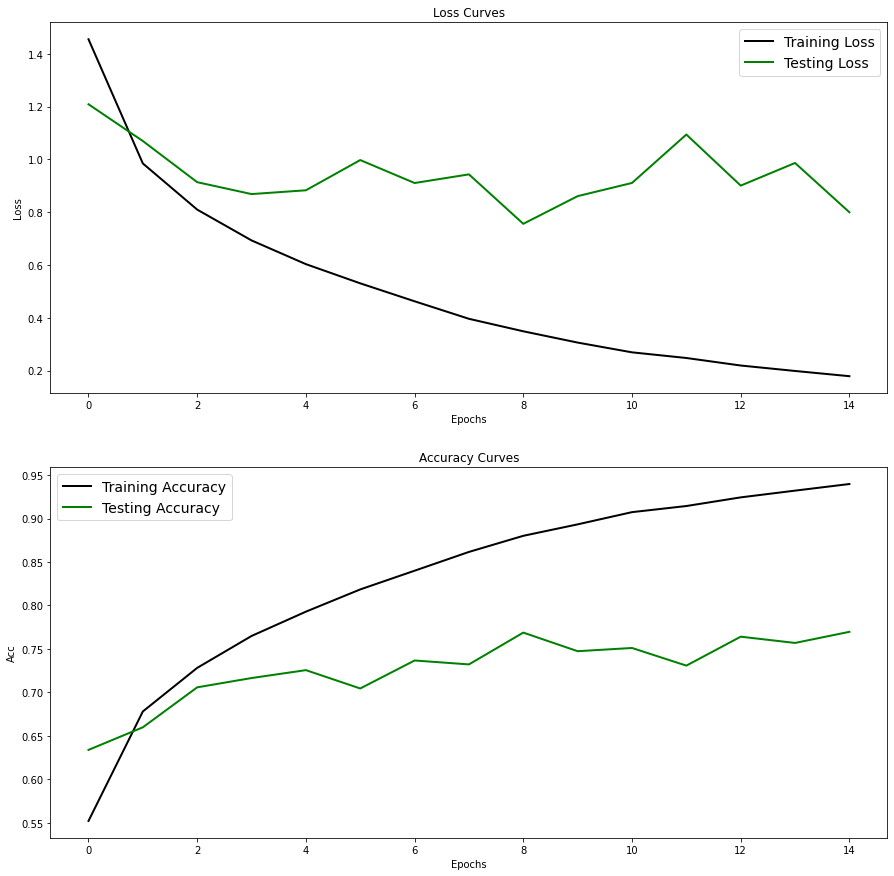

In [ ]:
#Потери
plt.figure(figsize=[15,15])
plt.subplot(211)
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Testing Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)
#Точность
plt.subplot(212)
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'green', linewidth=2.0)
plt.legend(['Training Accuracy', 'Testing Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Acc', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

In [ ]:
test_loss, test_acc = VGG16_model.evaluate(x_test, y_test)
print('Test loss: {}\nTest accuracy: {}'.format(test_loss, test_acc))

313/313 [==============================] - 26s 72ms/step - loss: 0.7999 - accuracy: 0.7697
Test loss: 0.7998692393302917
Test accuracy: 0.7696999907493591


# 2. Частичная сеть и тонкая настройка классификатора


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Resizing

vgg16_2 = applications.VGG16(weights='imagenet',
                    include_top=False,
                    classes=10,
                    input_shape=(None,None,3)
                   )
VGG16_model_2 = Sequential()
VGG16_model_2.add(Resizing(256,256))
for layer in vgg16.layers:
    VGG16_model_2.add(layer)
VGG16_model_2.add(Flatten())
VGG16_model_2.add(Dense(512, activation='relu', name='hidden1'))
VGG16_model_2.add(BatchNormalization())
VGG16_model_2.add(Dropout(0.5))
VGG16_model_2.add(Dense(256, activation='relu', name='hidden2'))
VGG16_model_2.add(BatchNormalization())
VGG16_model_2.add(Dropout(0.5))
VGG16_model_2.add(Dense(10, activation='softmax', name='predictions'))

VGG16_model_2.build((None,None,None,3))

In [ ]:
for layer in VGG16_model_2.layers[:14]:
    layer.trainable = False

VGG16_model_2.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(lr=0.0001),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='cifar10-VGG16.h5', verbose=1, save_best_only=True)

history_2=VGG16_model_2.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=20,
    verbose=1,
    callbacks=[checkpointer],
    validation_data=(x_test, y_test),
    shuffle=True)

Epoch 1/20
782/782 [==============================] - 134s 171ms/step - loss: 0.9591 - accuracy: 0.6895 - val_loss: 0.7517 - val_accuracy: 0.7563

Epoch 00001: val_loss improved from inf to 0.75171, saving model to cifar10-VGG16.h5
Epoch 2/20
782/782 [==============================] - 133s 170ms/step - loss: 0.5058 - accuracy: 0.8285 - val_loss: 0.8462 - val_accuracy: 0.7509

Epoch 00002: val_loss did not improve from 0.75171
Epoch 3/20
782/782 [==============================] - 133s 170ms/step - loss: 0.3600 - accuracy: 0.8770 - val_loss: 1.0451 - val_accuracy: 0.7272

Epoch 00003: val_loss did not improve from 0.75171
Epoch 4/20
782/782 [==============================] - 133s 170ms/step - loss: 0.2863 - accuracy: 0.9018 - val_loss: 0.8522 - val_accuracy: 0.7556

Epoch 00004: val_loss did not improve from 0.75171
Epoch 5/20
782/782 [==============================] - 133s 170ms/step - loss: 0.2307 - accuracy: 0.9208 - val_loss: 0.8274 - val_accuracy: 0.7698

Epoch 00005: val_loss did n

Text(0.5, 1.0, 'Accuracy Curves')

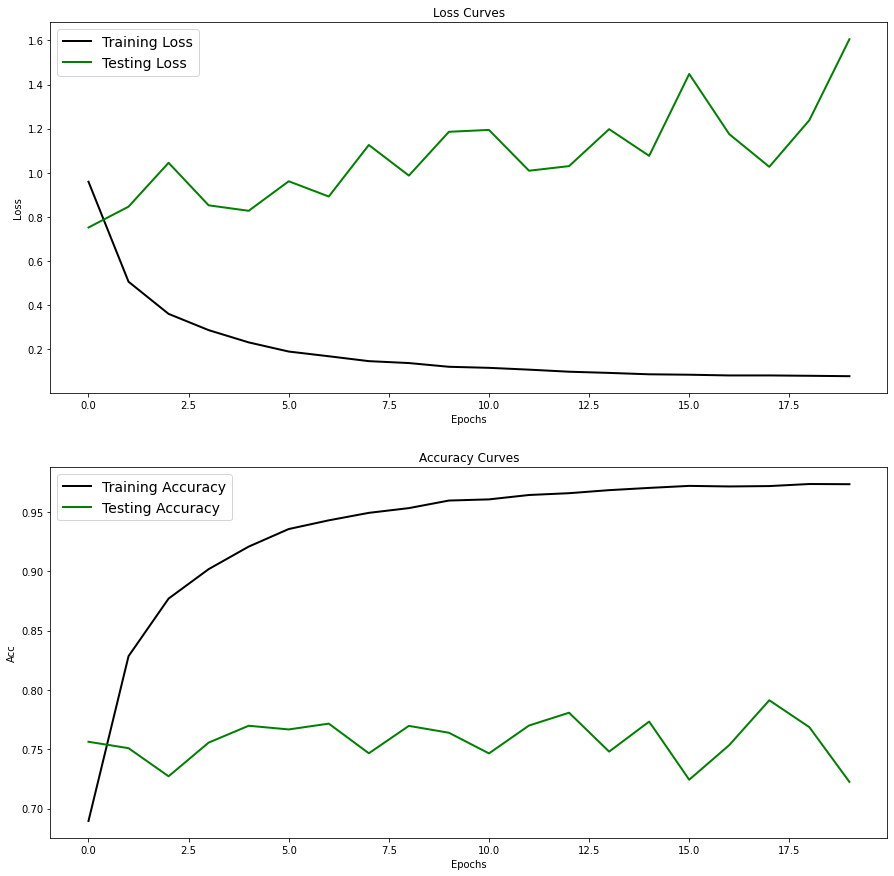

In [ ]:
#Потери
plt.figure(figsize=[15,15])
plt.subplot(211)
plt.plot(history_2.history['loss'], 'black', linewidth=2.0)
plt.plot(history_2.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Testing Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)
#Точность
plt.subplot(212)
plt.plot(history_2.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history_2.history['val_accuracy'], 'green', linewidth=2.0)
plt.legend(['Training Accuracy', 'Testing Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Acc', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

Как видно из следующего рисунка, в процессе обучения наблюдается явная проблема чрезмерной подгонки. По мере обучения возникает большой разрыв между обучающим и тестовым множеством, а функция потерь тестового множества сначала уменьшается, а затем увеличивается. Однако функция потерь обучающего множества продолжает уменьшаться, в то время как точность тестового множества в основном остается неизменной в более поздний период.

In [ ]:
test_loss, test_acc = VGG16_model_2.evaluate(x_test, y_test)
print('Test loss: {}\nTest accuracy: {}'.format(test_loss, test_acc))

313/313 [==============================] - 23s 72ms/step - loss: 1.6053 - accuracy: 0.7226
Test loss: 1.6053141355514526
Test accuracy: 0.722599983215332
